# DL

In [ ]:
!pip install emoji
!pip install pymorphy3
!pip install --ignore-installed gensim

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 9.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but yo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
import emoji
import re
from transformers import pipeline
import pymorphy3
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.optim import lr_scheduler
import os
from tqdm.auto import tqdm
from IPython.display import clear_output
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from collections import Counter, OrderedDict
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(device)

cuda


#### 1. Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, поизучать текста, сделать выводы.

In [3]:
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')

В трейне 29568 строк и 3 столбца:
* `id` - идентификационный номер (просто номер по-порядку),
* `text` - текст,
* `labels` - класс (20-значное число в двоичном коде) *сохранено не как число*

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29568 entries, 0 to 29567
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    29568 non-null  object
 1   labels  29568 non-null  object
dtypes: object(2)
memory usage: 693.0+ KB


In [5]:
train.duplicated().sum()

2114

Посмотрим на баланс классов

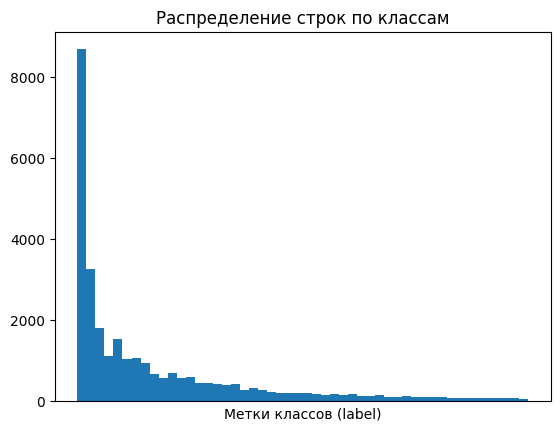

In [6]:
plt.hist(data=train, x='labels', bins=50)
plt.xticks([])
plt.title('Распределение строк по классам')
plt.xlabel('Метки классов (label)')
plt.show()

Посмотрим на представителей классов (случайный)

In [7]:
random.seed(42)

random_label = random.choice(train['labels'])
sample_len = min(train[train['labels'] == random_label]['text'].shape[0], 3)

print(f'Для класса с меткой {random_label} выведены первые 3 предсиавителей классов')
print(f'(или все доступные, если меньше 3 записей):')
for ind in range(sample_len):
    print(train[train['labels'] == random_label]['text'].iloc[ind])
    print('------------------------------------------------------')

Для класса с меткой 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 выведены первые 3 предсиавителей классов
(или все доступные, если меньше 3 записей):
Впервые в Уфе танцевальная терапия в группе с практикующим психологом
Тема встречи: «Отношения. Доверие. Контакт»
Приходите, если:
🔸
вы хотите наладить или поисследовать свои отношения с
-  телом
- собой
- близким человеком
- работой
- деньгами
🔸
не можете разрешить или забыть какую-то  ситуацию, связанную с отношениями
🔸
не умеете доверять или делегировать
🔸
тяжело вступаете в контакт
Задать вопрос психологу курса
и записаться можно здесь:
@LeontevaKsenia
Дата
: 26 января
Время
: 19.00-21.00
Адрес
: Коммунистическая, 45/3, Б/ц "Деловой двор"
Стоимость: 1500
Что нужно для занятия:
удобная одежда, носки, вода, желание танцевать.
------------------------------------------------------
11 декабря в 11:00 НЕТВОРКИНГ на 300+ человек с Владиславом БЕРМУДА
Для тех, кто хочет:
⁃ привлекать клиентов без затрат на рекламу
⁃ создать стратегию роста х2
⁃ з

Изучение данных на первых парах говорит, что это база данных с объявлением событий, где каждый класс представляет собой что? Есть гипотеза, что это парсер с каких-то тематических групп с объявлениями. Тогда каждый класс - объявления конкретной группы. Возможно, это посты-лайки конкретного пользователя. В общем, нужен контекст - неочевидно.

Попробуем поизучать следующие моменты:
* кол-во символов в объявлениях
* кол-во слов в объявлениях
* кол-во смайликов в объявлениях

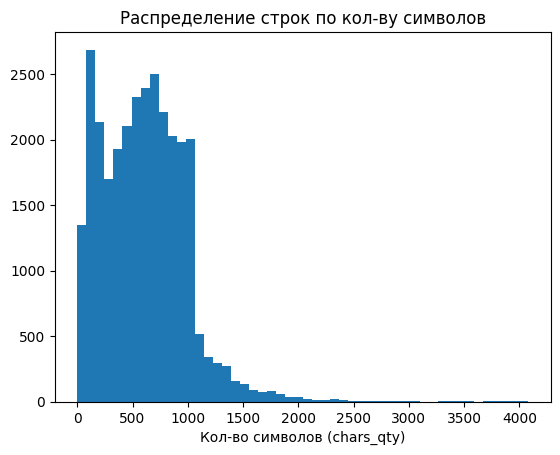

Среднее кол-во символов в строке: 604.8123308982684


In [8]:
train_eda = train.copy()

# учитываем перенос строки /n как 1 символ, а не 2
def count_chars(text):
    return len(text.replace('\n', ' '))

train_eda['chars_qty'] = train_eda['text'].apply(count_chars)

plt.hist(data=train_eda, x='chars_qty', bins=50)
# plt.xticks([])
plt.title('Распределение строк по кол-ву символов')
plt.xlabel('Кол-во символов (chars_qty)')
plt.show()

print(f'Среднее кол-во символов в строке: {train_eda["chars_qty"].mean()}')

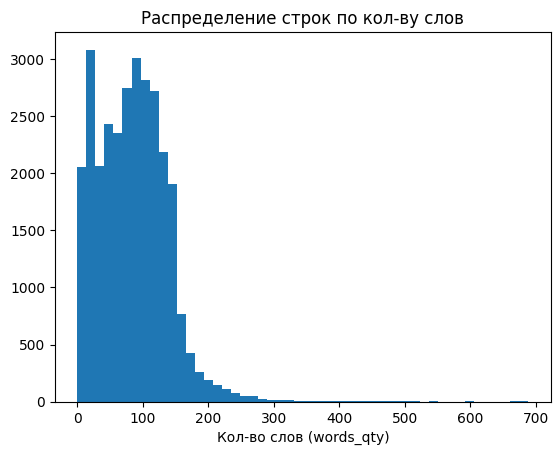

Среднее кол-во символов в строке: 84.0487012987013


In [9]:
# учитываем перенос строки /n как разделитель, избавляемся от смайликов (не считаем за слова), ссылка - одно слово
def count_words(text):
    text = text.replace('\n', ' ')
    text = emoji.replace_emoji(text, '')
    text = re.sub(r'https?://\S+', ' _ссылка_ ', text)
    words = re.findall(r'[a-zA-Zа-яА-ЯёЁ0-9\'-]+', text)
    return len(words)

train_eda['words_qty'] = train_eda['text'].apply(count_words)

plt.hist(data=train_eda, x='words_qty', bins=50)
plt.title('Распределение строк по кол-ву слов')
plt.xlabel('Кол-во слов (words_qty)')
plt.show()

print(f'Среднее кол-во символов в строке: {train_eda["words_qty"].mean()}')

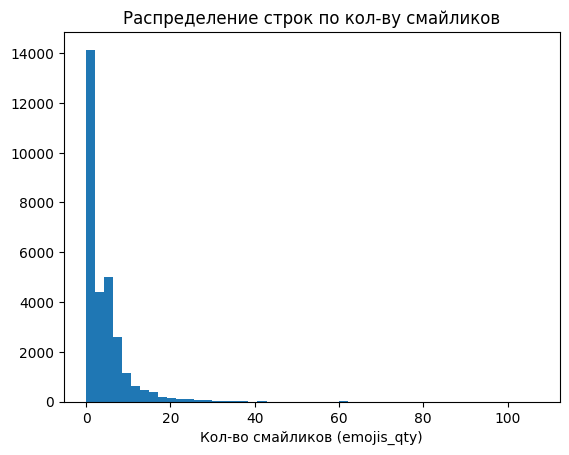

Среднее кол-во эмоджив строке: 4.039265422077922


In [10]:
def count_emojis(text):
    emoji_list = [c for c in text if c in emoji.EMOJI_DATA]
    return len(emoji_list)

train_eda['emojis_qty'] = train_eda['text'].apply(count_emojis)

plt.hist(data=train_eda, x='emojis_qty', bins=50)
plt.title('Распределение строк по кол-ву смайликов')
plt.xlabel('Кол-во смайликов (emojis_qty)')
plt.show()

print(f'Среднее кол-во эмоджив строке: {train_eda["emojis_qty"].mean()}')

#### 2. Проанализировать, какие очистки текста необходимы под разные способы токенизации и задания эмбеддингов для этой задачи:
#### (1) tf-idf + любая нейронная сеть;
#### (2) w2v + любая нейронная сеть;
#### (3) встроенный эмбеддинг в нейросетевое решение на свёрточных сетях;
#### (4) встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях;
#### (5) эмбеддер + решение на bert-like моделях (любой вид).
#### Создать пайплайны очистки текста и очистить.

| Метод            | Обработка регистра | Обработка эмодзи  | Обработка ссылок | Обработка пунктуации | Лемматизация | Особые токены        | Причина                                                                 |
|------------------|-------------------|------------------|------------------|----------------------|--------------|----------------------|-------------------------------------------------------------------------|
| **TF-IDF**       | ➖ Lowercase       | ➖ Удаление       | ➖ Замена на `[URL]` | ➖ Удаление          | ➖ Нет       | ➖ Нет               | Упрощение пространства признаков для "мешка слов"                       |
| **Word2Vec**     | ➖ Lowercase       | ➕ `[EMOJI]`      | ➕ `[URL]`        | ➖ Частично сохраняется | ➕ Да        | ➕ `[URL]`, `[EMOJI]` | Качественные word-embedding'ы требуют контекстной информации            |
| **CNN**          | ➕ Original        | ➕ `[EMOJI]`      | ➕ `[URL]`        | ➕ Сохраняется        | ➖ Нет       | ➕ `[URL]`, `[EMOJI]`, `[NL]` | Свёрточные сети анализируют символьные паттерны                         |
| **RNN**          | ➕ Original        | ➕ `[EMOJI]`      | ➕ `[URL]`        | ➕ Разделение         | ➖ Нет       | ➕ `[URL]`, `[EMOJI]`, `[NL]` | Важно сохранять последовательности для анализа временных зависимостей   |
| **BERT**         | ➕ Original        | ➕ `[EMOJI]`      | ➕ `[URL]`        | ➕ Сохраняется        | ➖ Нет       | ➕ `[URL]`, `[EMOJI]`, `[SEP]` | Собственный токенизатор обрабатывает сложные случаи                    |

**Условные обозначения**:
- ➕ Сохраняется/используется
- ➖ Удаляется/не используется
- `[URL]` - Специальный токен для ссылок
- `[EMOJI]` - Токен для эмодзи
- `[NL]` - Токен переноса строки (для CNN/RNN)
- `[SEP]` - Специальный токен для BERT

In [11]:
def preprocess_text(text, method='bert'):
    text = str(text)

    # переносы строк
    if method in ['tfidf', 'w2v']:
        text = text.replace('\n', ' ')
    else:
        text = text.replace('\n', ' [NL] ')

    # сылки
    text = re.sub(r'https?://\S+|www\.\S+', ' [URL] ', text)

    # эмодзи
    text = emoji.replace_emoji(text, replace=' [EMOJI] ')

    # лемматизация и пунктуация взависимости от модели
    if method == 'tfidf':
        text = re.sub(r'[^\w\s]', ' ', text.lower())
        text = ' '.join([word for word in text.split() if len(word) > 2])

    elif method == 'w2v':
        text = re.sub(r'([.!?])', r' \1 ', text.lower())
        analyzer = pymorphy3.MorphAnalyzer()
        text = ' '.join([analyzer.parse(word)[0].normal_form if word not in ['[URL]', '[EMOJI]', '[NL]']
                        else word for word in text.split()])

    elif method == 'cnn':
        text = re.sub(r'(\W)', r' \1 ', text)

    elif method == 'rnn':
        text = re.sub(r'([.,!?()])', r' \1 ', text)

    return ' '.join(text.split()).strip()

In [12]:
def preprocess_dataset(df, method='bert'):
  df['cleaned_text'] = df['text'].apply(lambda x: preprocess_text(x, method))
  df_cleaned = df.copy()
  if 'labels' in df.columns.to_list():
    df_cleaned = df_cleaned[['cleaned_text','labels']]
  else:
    df_cleaned = df_cleaned[['cleaned_text']]
  return df_cleaned

#### 3. Поделить данные на трейн-валидацию, обучить все модели из п.2. Снабдить обучение моделей графиками отрисовки лосей и метрик, шедулерами, свитч лосей (метрик), сохранение лучшей модели, ранней остановкой, вормапом.

In [13]:
train, val = train_test_split(train, test_size=0.2, random_state=42)

##### Пропишем обучение

In [14]:
class NeuralNetClassifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=256):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)

    def predict(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        return self.layer2(x)

    def forward(self, x):
        return self.predict(x)

def run_training_cycle(model, data_loader, loss_fn, optim, dev):
    model.train()
    total_loss = 0.0

    for features, targets in data_loader:
        features, targets = features.to(dev), targets.to(dev)

        optim.zero_grad()
        predictions = model.predict(features)
        current_loss = loss_fn(predictions, targets.float())

        current_loss.backward()
        optim.step()

        total_loss += current_loss.item() * features.shape[0]

    return total_loss / len(data_loader.dataset)

def validate(model, val_loader, loss_fn, dev):
    model.eval()
    loss_total = 0.0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(dev), labels.to(dev)

            outputs = model.predict(inputs)
            loss_total += loss_fn(outputs, labels.float()).item() * inputs.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()

            true_labels.append(labels.cpu().numpy())
            pred_labels.append(preds.cpu().numpy())

    avg_loss = loss_total / len(val_loader.dataset)
    f1 = f1_score(np.concatenate(true_labels), np.concatenate(pred_labels), average='macro', zero_division=0)

    return avg_loss, f1

def visualize_results(epoch_numbers, train_loss_values, val_loss_values, f1_scores, best_epoch):
    plt.figure(figsize=(15, 6))

    sns.set_style("whitegrid")
    palette = sns.color_palette("husl", 3)

    plt.subplot(1, 2, 1)
    sns.lineplot(x=epoch_numbers, y=train_loss_values,
                 label='Training Loss', color=palette[0], linewidth=2)
    sns.lineplot(x=epoch_numbers, y=val_loss_values,
                 label='Validation Loss', color=palette[1], linewidth=2)
    plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label='Best Epoch')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14)
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.lineplot(x=epoch_numbers, y=f1_scores,
                 label='F1 Macro Score', color=palette[2], linewidth=2)
    plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label='Best Epoch')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.title('Validation F1 Macro Score', fontsize=14)
    plt.legend()

    plt.tight_layout()
    plt.show()

def execute_training(
    model,
    train_loader,
    val_loader,
    loss_function,
    primary_optimizer,
    total_epochs,
    secondary_optimizer=None,
    monitored_metric="f1_macro",
    patience_threshold=5,
    early_stop_patience=None,
    lr_scheduler=None,
    compute_device=device,
    model_save_path="models/best_model.pt",
):
    model.to(compute_device)
    epoch_bar = tqdm(range(1, total_epochs + 1), desc='Training', leave=True)

    optimizer = primary_optimizer
    scheduler = lr_scheduler

    history_train_loss = []
    history_val_loss = []
    history_f1 = []

    if monitored_metric == "f1_macro":
        best_score = -np.inf
        is_better = lambda x, y: x > y
    elif monitored_metric == "val_loss":
        best_score = np.inf
        is_better = lambda x, y: x < y

    no_improvement_count = 0
    optimizer_changed = False
    optimal_epoch = -1

    for current_epoch in epoch_bar:
        epoch_bar.set_description(f"Epoch {current_epoch}/{total_epochs}")
        train_loss = run_training_cycle(model, train_loader, loss_function, optimizer, compute_device)
        history_train_loss.append(train_loss)
        val_loss, val_f1 = validate(model, val_loader, loss_function, compute_device)
        history_val_loss.append(val_loss)
        history_f1.append(val_f1)

        current_metric = val_f1 if monitored_metric == "f1_macro" else val_loss
        if is_better(current_metric, best_score):
            best_score = current_metric
            no_improvement_count = 0
            os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
            torch.save(model.state_dict(), model_save_path)
            optimal_epoch = current_epoch
            improvement_msg = f"★ Improved {monitored_metric} to {best_score:.4f} ★"
            epoch_bar.write(improvement_msg)
        else:
            no_improvement_count += 1
        postfix = {
            'train_loss': f"{train_loss:.4f}",
            'val_loss': f"{val_loss:.4f}",
            'val_f1': f"{val_f1:.4f}",
            'no_imp': no_improvement_count,
            'lr': f"{optimizer.param_groups[0]['lr']:.2e}"
        }
        epoch_bar.set_postfix(postfix)
        if (not optimizer_changed and secondary_optimizer is not None
            and no_improvement_count >= patience_threshold):
            optimizer = secondary_optimizer
            optimizer_changed = True
            no_improvement_count = 0
            scheduler = None
            switch_msg = (f"\n⚠ Switching to {optimizer.__class__.__name__} "
                         f"with LR={optimizer.param_groups[0]['lr']:.2e} ⚠")
            epoch_bar.write(switch_msg)
        if scheduler is not None:
            scheduler.step()
        if (early_stop_patience is not None
            and no_improvement_count >= early_stop_patience):
            stop_msg = (f"\n Early stopping at epoch {current_epoch} "
                       f"(no improvement for {early_stop_patience} epochs)")
            epoch_bar.write(stop_msg)
            break
        if current_epoch % 2 == 0 or current_epoch == total_epochs:
            clear_output(wait=True)
            visualize_results(
                list(range(1, len(history_train_loss) + 1)),
                history_train_loss,
                history_val_loss,
                history_f1,
                optimal_epoch
            )
            epoch_bar.refresh()
    if os.path.exists(model_save_path):
        model.load_state_dict(torch.load(model_save_path))
        epoch_bar.write(f"\n Best model loaded from {model_save_path} ✔")
    clear_output(wait=True)
    visualize_results(
        list(range(1, len(history_train_loss) + 1)),
        history_train_loss,
        history_val_loss,
        history_f1,
        optimal_epoch
    )

    return model

и функцию для формирования сабмишн

In [15]:
def create_submission_predictions(trained_model, text_samples, sample_ids, computation_device, text_vectorizer):
    trained_model.eval()
    batch_predictions = []

    features = text_vectorizer.transform(text_samples)
    features_tensor = torch.tensor(features.todense(), dtype=torch.float32)
    prediction_dataset = TensorDataset(features_tensor)
    prediction_loader = DataLoader(prediction_dataset, batch_size=32, shuffle=False)

    with torch.no_grad():
        for batch in prediction_loader:
            inputs = batch[0].to(computation_device)
            model_output = trained_model(inputs)

            binary_preds = (torch.sigmoid(model_output) > 0.5).long()
            batch_predictions.append(binary_preds.cpu().numpy())

    final_predictions = np.vstack(batch_predictions)

    formatted_labels = [" ".join(map(str, pred_row)) for pred_row in final_predictions]

    submission_df = pd.DataFrame({
        "id": sample_ids,
        "labels": formatted_labels
    })

    return submission_df

##### 3.1 tf-idf + любая нейронная сеть

In [16]:
processed_train = preprocess_dataset(train, 'tfidf')
processed_val = preprocess_dataset(val, 'tfidf')
processed_test = preprocess_dataset(test, 'tfidf')

training_texts = processed_train['cleaned_text'].to_list()
validation_texts = processed_val['cleaned_text'].to_list()
test_texts = processed_test['cleaned_text'].to_list()

text_vectorizer = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.95)
text_vectorizer.fit(training_texts)

train_features = text_vectorizer.transform(training_texts)
val_features = text_vectorizer.transform(validation_texts)

train_labels = processed_train['labels'].to_list()
val_labels = processed_val['labels'].to_list()

train_label_vectors = [np.array(list(map(int, s.split()))) for s in train_labels]
val_label_vectors = [np.array(list(map(int, s.split()))) for s in val_labels]

y_train_tensor = torch.tensor(train_label_vectors, dtype=torch.float)
y_val_tensor = torch.tensor(val_label_vectors, dtype=torch.float)

X_train_tensor_tfidf = torch.from_numpy(train_features.todense()).float()
X_val_tensor_tfidf = torch.from_numpy(val_features.todense()).float()

tfidf_train_dataset = TensorDataset(X_train_tensor_tfidf, y_train_tensor)
tfidf_val_dataset = TensorDataset(X_val_tensor_tfidf, y_val_tensor)

train_loader_tfidf = DataLoader(
    tfidf_train_dataset,
    batch_size=64,
    shuffle=True
)
val_loader_tfidf = DataLoader(
    tfidf_val_dataset,
    batch_size=64,
    shuffle=False
)

<ipython-input-16-0d909fbc3cea>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  y_train_tensor = torch.tensor(train_label_vectors, dtype=torch.float)


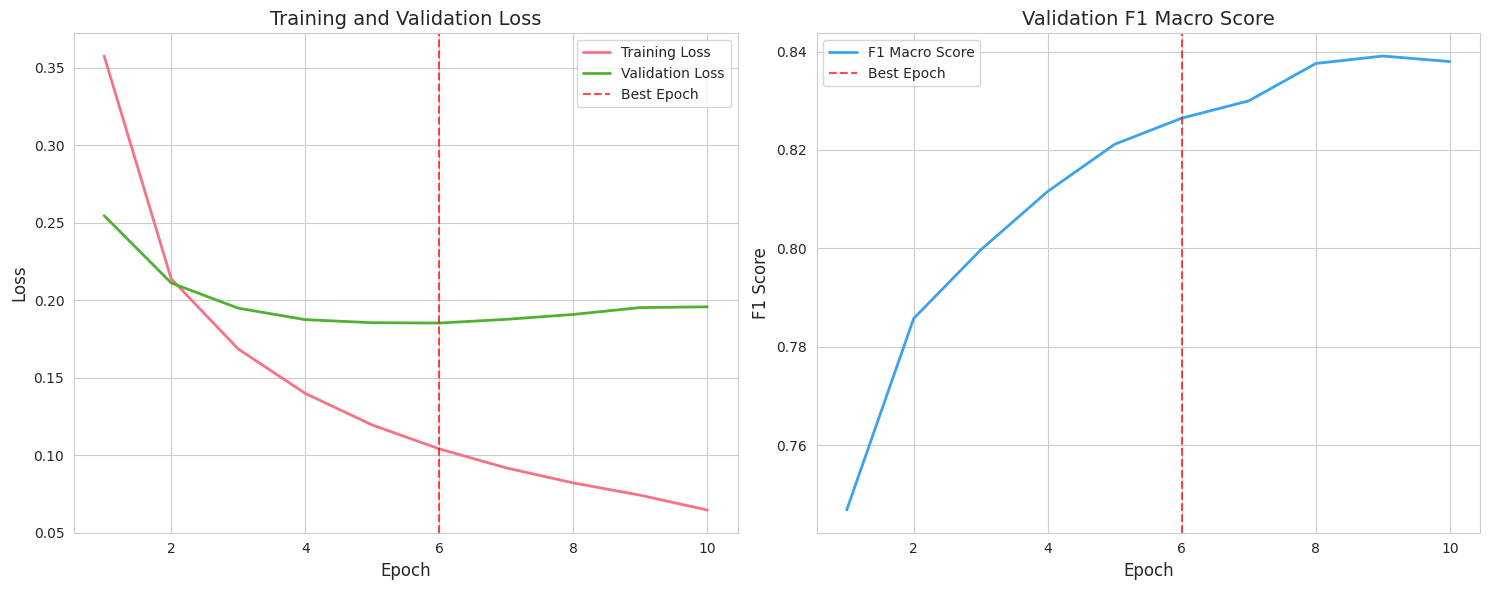

In [17]:
model_tfidf = NeuralNetClassifier(
    input_size=val_features.shape[1],
    output_size=y_train_tensor.shape[1],
    hidden_size=256,
).to(device)

loss_fn = nn.BCEWithLogitsLoss()
main_optimizer = optim.AdamW(model_tfidf.parameters(), lr=1e-3)
backup_optimizer = optim.AdamW(model_tfidf.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(main_optimizer, T_max=20)

training_output = execute_training(
    model=model_tfidf,
    train_loader=train_loader_tfidf,
    val_loader=val_loader_tfidf,
    loss_function=loss_fn,
    primary_optimizer=main_optimizer,
    total_epochs=10,
    secondary_optimizer=backup_optimizer,
    monitored_metric="val_loss",
    patience_threshold=3,
    lr_scheduler=scheduler,
    early_stop_patience=5,
    compute_device=device,
    model_save_path="models/tf_idf.pt"
)

In [18]:
submissions = create_submission_predictions(model_tfidf, processed_test['cleaned_text'], processed_test.index.to_list(), device, text_vectorizer)
submissions.to_csv("submission_tfidf.csv", index=False)

**Этот `submissions` (tf-idf) использовался на кагле!**

##### 3.2 W2V

In [19]:
def process_text_sequences(text_sequences, default_token="[MISSING]"):
    processed = []
    for seq in text_sequences:
        if not isinstance(seq, str):
            continue

        tokens = seq.split() if seq.strip() else [default_token]
        processed.append(tokens)
    return processed


def compute_text_representations(token_seqs, embedding_model=None, default_dim=100):
    if embedding_model is None:
        return np.zeros((len(token_seqs), default_dim))

    vec_size = embedding_model.vector_size
    results = []

    for tokens in token_seqs:
        valid_vecs = []
        for token in tokens:
            try:
                valid_vecs.append(embedding_model.wv[token])
            except (KeyError, AttributeError):
                continue

        if valid_vecs:
            results.append(np.mean(valid_vecs, axis=0))
        else:
            results.append(np.zeros(vec_size))

    return torch.FloatTensor(np.array(results))


class NeuralTextClassifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64, dropout=0.2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.layers(x)


def make_predictions(model, texts, ids, device, embedding_provider=None, batch_size=64, threshold=0.45):
    model.eval()
    predictions = []
    if embedding_provider is not None:
        tokenized = process_text_sequences(texts)
        vectors = compute_text_representations(tokenized, embedding_provider)
        dataset = TensorDataset(vectors)

    loader = DataLoader(dataset, batch_size=batch_size)
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            batch_preds = (torch.sigmoid(outputs) > threshold).int()
            predictions.append(batch_preds.cpu())
    predictions = torch.cat(predictions).numpy()
    results = pd.DataFrame({
        "id": ids,
        "labels": [" ".join(map(str, row)) for row in predictions]
    })

    return results

In [20]:
train_processed = process_text_sequences(processed_train['cleaned_text'].to_list())
val_processed = process_text_sequences(processed_val['cleaned_text'].to_list())

text_embedder = Word2Vec(
    sentences=train_processed,
    vector_size=128,
    window=7,
    min_count=3,
    workers=8,
    epochs=50
)

net = NeuralTextClassifier(
    input_size=128,
    output_size=processed_train.shape[1],
    hidden_size=64,
    dropout=0.3
).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

predictions = make_predictions(
    model=net,
    texts=processed_test['cleaned_text'],
    ids=processed_test.index.to_list(),
    device=device,
    embedding_provider=text_embedder,
    threshold=0.4
)

##### 3.3 и 3.4 встроенный эмбеддинг в нейросетевое решение на свёрточных и рекурентых сетях

In [21]:
class TextProcessor:
    def __init__(self, default_token="[MISSING]"):
        self.default_token = default_token

    def process_text(self, text):
        if not isinstance(text, str):
            return [self.default_token]

        cleaned = text.strip().lower()
        return cleaned.split() if cleaned else [self.default_token]


class TextVocabulary:
    def __init__(self, special_tokens=None):
        self.special_tokens = special_tokens or ["[PAD]", "[UNK]", "[EMPTY]"]
        self.token_to_id = {token: i for i, token in enumerate(self.special_tokens)}
        self.id_to_token = self.special_tokens.copy()

    def create_from_texts(self, tokenized_texts, max_vocab_size=15000, min_count=2):
        word_counts = Counter()
        for tokens in tokenized_texts:
            word_counts.update(tokens)

        sorted_words = sorted(word_counts.items(), key=lambda x: (-x[1], x[0]))

        for word, count in sorted_words:
            if count >= min_count and word not in self.token_to_id:
                if max_vocab_size and len(self.token_to_id) >= max_vocab_size:
                    break
                self.token_to_id[word] = len(self.id_to_token)
                self.id_to_token.append(word)

    def encode(self, tokens):
        return [self.token_to_id.get(token, self.token_to_id["[UNK]"])
               for token in tokens]

    def __len__(self):
        return len(self.id_to_token)


class TextDataset(Dataset):
    def __init__(self, texts, labels, processor, vocab, max_seq_len=120):
        self.texts = texts
        self.labels = [self._parse_labels(l) for l in labels]
        self.processor = processor
        self.vocab = vocab
        self.max_len = max_seq_len

    def _parse_labels(self, label_str):
        if isinstance(label_str, str):
            return [float(x) for x in label_str.split()]
        return label_str

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tokens = self.processor.process_text(self.texts[idx])
        encoded = self.vocab.encode(tokens[:self.max_len])
        label = self.labels[idx]

        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.float)
        )


def pad_collate(batch, pad_idx=0):
    texts, labels = zip(*batch)
    max_len = max(len(x) for x in texts)
    padded_texts = torch.stack([
        torch.cat([
            t,
            torch.full((max_len - len(t),), pad_idx, dtype=torch.long)
        ])
        for t in texts
    ])

    return padded_texts, torch.stack(labels)


class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, num_filters=128,
                 kernel_sizes=[3,4,5], num_classes=20, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, ks)
            for ks in kernel_sizes
        ])

        self.classifier = nn.Sequential(
            nn.Linear(num_filters * len(kernel_sizes), 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = [F.relu(conv(x)) for conv in self.convs]
        x = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in x]
        x = torch.cat(x, 1)
        return self.classifier(x)

class BiRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=80, hidden_size=200,
                 num_layers=2, num_classes=20, dropout=0.4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, hidden_size, num_layers,
                         bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        embedded = self.embedding(x).permute(1, 0, 2)
        _, hidden = self.rnn(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.fc(hidden)

In [22]:
processor = TextProcessor()
vocab = TextVocabulary(special_tokens=["[PAD]", "[UNK]", "[EMPTY]"])

tokenized_texts = [processor.process_text(text) for text in training_texts]
vocab.create_from_texts(tokenized_texts, max_vocab_size=12000)

if "[PAD]" not in vocab.token_to_id:
    vocab.token_to_id["[PAD]"] = 0
    vocab.id_to_token.insert(0, "[PAD]")

train_labels_np = np.array([list(map(float, label_str.split()))
                          for label_str in train_labels])

train_dataset = TextDataset(training_texts, train_labels, processor, vocab)
train_loader = DataLoader(train_dataset, batch_size=256,
                         collate_fn=lambda b: pad_collate(b, vocab.token_to_id["[PAD]"]))

model = TextCNN(
    vocab_size=len(vocab),
    num_classes=train_labels_np.shape[1]
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

for epoch in range(10):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.binary_cross_entropy_with_logits(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}')
    scheduler.step()

Epoch 1, Loss: 0.4201
Epoch 2, Loss: 0.3195
Epoch 3, Loss: 0.2903
Epoch 4, Loss: 0.2758
Epoch 5, Loss: 0.2731
Epoch 6, Loss: 0.2708
Epoch 7, Loss: 0.2690
Epoch 8, Loss: 0.2697
Epoch 9, Loss: 0.2693
Epoch 10, Loss: 0.2686


##### 3.5 эмбеддер + решение на bert-like моделях

In [23]:
MODEL_NAME = 'cointegrated/rubert-tiny'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME).to(device)

def parse_labels(labels):
    return np.array([list(map(float, label_str.split())) for label_str in labels])

train_labels_np = parse_labels(train_labels)
val_labels_np = parse_labels(val_labels)

class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

class BertClassifier(nn.Module):
    def __init__(self, bert_model, num_classes, dropout=0.3):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

model = BertClassifier(bert_model, num_classes=train_labels_np.shape[1]).to(device)
train_dataset = BertDataset(training_texts, train_labels_np, tokenizer)
val_dataset = BertDataset(validation_texts, val_labels_np, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0

    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = F.binary_cross_entropy_with_logits(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(3):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}')

def predict(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.sigmoid(outputs) > 0.5
            predictions.extend(preds.cpu().numpy())

    return predictions

test_predictions = predict(model, val_loader, device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Epoch: 1, Train Loss: 0.3343
Epoch: 2, Train Loss: 0.2643
Epoch: 3, Train Loss: 0.2372


#### 4. Запросить у модели декодер сгенерировать примеры с тем же распределением меток, что и у данных. Обогатить этими данными датасет (добавить хотя бы 1000 наблюдений). Проверить свой лучший пайплайн на улучшение/уменьшение качества модели вместе со сгенерированными данными. Сделать выводы и объяснить результат.

In [ ]:
generator_tokenizer = GPT2Tokenizer.from_pretrained("sberbank-ai/rugpt3medium_based_on_gpt2")
generator_model = GPT2LMHeadModel.from_pretrained("sberbank-ai/rugpt3medium_based_on_gpt2").to(device)
generator_tokenizer.pad_token = generator_tokenizer.eos_token

label_distribution = train_labels_np.mean(axis=0)
num_classes = train_labels_np.shape[1]

def generate_text_for_labels(labels, max_length=100):
    prompt = f"Текст мероприятия с метками {labels}:\n"
    inputs = generator_tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = generator_model.generate(
            **inputs,
            max_length=max_length,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            num_return_sequences=1
        )

    generated = generator_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated[len(prompt):].strip()

def generate_synthetic_dataset(num_samples=1000):
    synthetic_texts = []
    synthetic_labels = []

    for _ in tqdm(range(num_samples), desc="Generating samples"):
        labels = (np.random.rand(num_classes) < label_distribution).astype(int)

        try:
            text = generate_text_for_labels(" ".join(map(str, labels)))
            synthetic_texts.append(text)
            synthetic_labels.append(labels)
        except Exception as e:
            print(f"Error: {e}")
            continue

    return synthetic_texts, np.array(synthetic_labels)

syn_texts, syn_labels = generate_synthetic_dataset(1000)

augmented_texts = np.concatenate([training_texts, syn_texts])
augmented_labels = np.concatenate([train_labels_np, syn_labels])

augmented_dataset = BertDataset(augmented_texts, augmented_labels, tokenizer)
augmented_loader = DataLoader(augmented_dataset, batch_size=16, shuffle=True)

for epoch in range(2):
    train_loss = train_epoch(model, augmented_loader, optimizer, device)
    print(f"Augmentation Epoch {epoch+1}, Loss: {train_loss:.4f}")

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

Generating samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
syn_texts

Добавление аугментации ухудшило скор на валидации, поэтому в итоговый вариант не вошло

**Ещё раз - финальная модель tf-idf (сохранена в `submission`)**

In [ ]:
submissions